In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['pdf.use14corefonts'] = True

import numba
import numba.typed

from pathlib import Path
import tqdm
import sys
import seaborn as sns
import scipy.stats
import os
import joblib
import io
import itertools
import warnings

from brokenaxes import brokenaxes


import polars as pl
pl.Config.set_tbl_rows(100);
pl.Config.set_fmt_str_lengths(50);


In [3]:
sys.path.append(str(Path(os.getcwd()).parent))
from src import liftover, annotate, diagnostics, inference
from src.IDs import *


# Create callset to infer from

In [4]:
ceph_good_samples = "NA12878,NA12879,NA12881,NA12882,NA12886,NA12892,200084,200085,200102,200104".split(',')

In [5]:
%%time
reads_df = pl.concat([
    pl.scan_parquet(
        f"/lustre/scratch122/tol/projects/sperm/results/CEPH_20241119/read_analysis/{sample_id}/{sample_id}/reads/{chrom}/all_reads_structure_annotated.parquet"
    ) 
    for sample_id in tqdm.tqdm(ceph_good_samples)
    for chrom in aut_chrom_names
])

100%|██████████| 10/10 [00:00<00:00, 2402.65it/s]

CPU times: user 6.77 ms, sys: 3.38 ms, total: 10.1 ms
Wall time: 9.8 ms


In [6]:
%%time
callset_df = inference.generate_call_set(reads_df, ceph_good_samples, take_every=10, min_snps=3, sample_every=1)

CPU times: user 15min 1s, sys: 7min 35s, total: 22min 36s
Wall time: 8min 15s


In [7]:
callset_df.shape

(4318196, 19)

In [ ]:
%%time
fast_callset_df = inference.generate_call_set(reads_df, ceph_good_samples[:1], take_every=10, min_snps=5)
fast_callset_df.shape

# Confirm number of COs makes sense?

## x..y, high snps

In [8]:
print(
    "# of observed 1-switches:",
    (callset_df
        .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 1)
        .select(pl.len()).item()
    ),
)

# of observed 1-switches: 338


In [9]:
print(
    "# of high quality expected 1-switches:",
    callset_df.select(
        (pl.col("between_high_quality_snps_cM").list.slice(
            1, 
            pl.col("between_high_quality_snps_cM").list.len() - 2,
        ).list.sum() * 1e-2).alias("prob")
    )
    ["prob"].sum()
)

# of high quality expected 1-switches: 550.690976204473


# See summary stats

In [10]:
(callset_df
    .select(pl.col("high_quality_snps_idx_transitions").list.len().alias("n_transitions"))
    .group_by("n_transitions")
    .len()
    .sort("n_transitions")
)

n_transitions,len
u32,u32
0,4317102
1,338
2,756


In [11]:
(callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

n_converted,len
i64,u32
1,741
2,11
4,4


In [21]:
ub = (callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"]
)

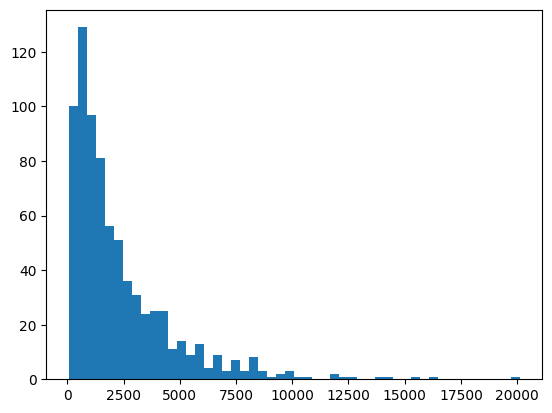

In [22]:
plt.hist(ub, bins=50);

# Test likelihood

## Focus on one read

In [113]:
row = {
    "read_length": 10000,
    "mid_quality_snp_positions": [4000, 5000, 6000],
    "between_mid_quality_snps_cM": [1e-2, 2e-2, 3e-2, 1e-2],
    "before_read_cM": 1e-3,
    "after_read_cM": 1e-3,
}


## Simulate from the model many times with this read pattern

In [109]:
n_reps = 1000000

res = inference.simulate_read_patterns_probs(
    numba.typed.List(np.repeat(row["read_length"], n_reps)),
    numba.typed.List([np.array(row["mid_quality_snp_positions"]) for x in range(n_reps)]),
    numba.typed.List([np.array(row["between_mid_quality_snps_cM"]) * 1e-2 for x in range(n_reps)]),
    numba.typed.List(np.repeat(row["before_read_cM"] * 1e-2, n_reps)),
    numba.typed.List(np.repeat(row["after_read_cM"] * 1e-2, n_reps)),
    q = 0.0,
    m = 1,
    GC_tract_mean = 30,
    GC_tract_mean2 = 1000,
    read_margin_in_bp = 5000,
    allow_flip = False,
)



sim_idx_transitions = [np.array([], dtype=np.int64) for i in range(n_reps)]
for i, lst in zip(res[1], res[0]):
    sim_idx_transitions[i] = np.array(lst, dtype=np.int64)
sim_idx_transitions = np.array(sim_idx_transitions, dtype=object)

n_detected_COs = np.sum([1 for x in sim_idx_transitions if len(x) == 1])
n_detected_NCOs = np.sum([1 for x in sim_idx_transitions if len(x) == 2])

print("# events:", len(res[0]))
print("# CO events:", res[3])
print("# detected CO events:", n_detected_COs)

print("# NCO events:", res[4])
print("# detected NCO events:", n_detected_NCOs)

print("# NCO first comp:", res[5])

# events: 3189
# CO events: 330
# detected CO events: 135
# NCO events: 2859
# detected NCO events: 0.0
# NCO first comp: 2859


In [119]:
idx_transitions = [0,1]

inference.likelihood_of_read_one_direction(
    row["read_length"],
    row["mid_quality_snp_positions"],
    numba.typed.List([999] + idx_transitions)[1:],  # hack for typing the list
    np.array(row["between_mid_quality_snps_cM"]) * 1e-2,
    row["before_read_cM"] * 1e-2,
    row["after_read_cM"] * 1e-2,
    q = 0.1,
    m = 1,
    GC_tract_mean = 30,
    GC_tract_mean2 = 1000,
    read_margin_in_bp = 5000,
)


5.39999999999998e-05

In [121]:
0.99935825 + 0.00020675000000000012 + 0.00038099999999999983 + 5.39999999999998e-05

1.0

# Test on simulations

In [14]:
%%time
idf = callset_df

res = inference.simulate_read_patterns_probs(
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    q = 0.142,
    m = 0.982,
    GC_tract_mean = 34.6,
    GC_tract_mean2 = 7216,
    read_margin_in_bp = 5000,
)

# res = inference.simulate_read_patterns_probs(
#     numba.typed.List(idf["read_length"].to_numpy()),
#     numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
#     numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
#     numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
#     numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
#     q = 0.128,
#     m = 0.97,
#     GC_tract_mean = 29.59,
#     GC_tract_mean2 = 652,
#     read_margin_in_bp = 5000,
# )


sim_idx_transitions = [np.array([], dtype=np.int64) for i in range(len(idf))]
for i, lst in zip(res[1], res[0]):
    sim_idx_transitions[i] = np.array(lst, dtype=np.int64)
#sim_idx_transitions = np.array(sim_idx_transitions, dtype=object)
sim_callset_df = (idf
    .with_columns(high_quality_snps_idx_transitions = pl.Series(sim_idx_transitions, dtype=pl.List(pl.Int64)))
)

n_detected_COs = np.sum([1 for x in sim_idx_transitions if len(x) == 1])
n_detected_NCOs = np.sum([1 for x in sim_idx_transitions if len(x) == 2])

n_detected_NCOs_from_NCOs = np.sum([1 for idx_trans, event_type in zip(res[0], res[6]) if event_type == 0 and len(idx_trans) == 2])
n_detected_COs_from_NCOs = np.sum([1 for idx_trans, event_type in zip(res[0], res[6]) if event_type == 0 and len(idx_trans) == 1])

print("# events:", len(res[0]))
print("# CO events:", res[3])
print("# detected CO events:", n_detected_COs)

print("# NCO events:", res[4])
print("# detected NCO events:", n_detected_NCOs)
print("# detected NCO events from NCOs:", n_detected_NCOs_from_NCOs)
print("# detected CO events from NCOs:", n_detected_COs_from_NCOs)

print("# NCO first comp:", res[5])


Working on 36970 events
# events: 36970
# CO events: 5235
# detected CO events: 2124
# NCO events: 31735
# detected NCO events: 435
# detected NCO events from NCOs: 435
# detected CO events from NCOs: 278
# NCO first comp: 31206
CPU times: user 3min 49s, sys: 32.2 s, total: 4min 22s
Wall time: 4min 22s


In [27]:
shorts = np.array([tract_length \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1])

longs = np.array([tract_length \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0])

shorts_frac_detected = np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 1]).mean()

long_frac_detected = np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0]).mean()


In [46]:
np.array([(len(idx_trans) > 0) \
     for idx_trans, event_type, tract_type, tract_length in zip(res[0], res[6], res[7], res[8]) \
     if event_type == 0 and tract_type == 0]).mean()


0.40831758034026466

In [47]:
0.31379962192816635 / 0.40831758034026466

0.7685185185185185

In [28]:
long_frac_detected

0.40831758034026466

Pr(NCO is long | detected NCO) = Pr(detected NCO | NCO is long) * Pr(NCO is long) / Pr(detected NCO)

Pr(detected NCO | NCO is short) = 0.016

Pr(detected NCO | NCO is long) = 0.4

Pr(NCO is short) = 0.982

Pr(NCO is long) = 0.018

Pr(detected NCO) = 0.982 * 0.016 + 0.4 * 0.018 = 0.023

Pr(NCO is long | detected NCO) = 0.4 * 0.018 / 0.023 = 0.31

In [ ]:
Pr(NCO is long | detected NCO as NCO) = Pr(detected NCO as NCO | NCO is long) * Pr(NCO is long) / Pr(detected NCO as NCO)

Pr(detected NCO as NCO | NCO is short) = 0.015 * 0.78 = 0.0117

Pr(detected NCO | NCO is long) = 0.4 * 0.23 = 0.092

Pr(NCO is short) = 0.98

Pr(NCO is long) = 0.02

Pr(detected NCO as NCO) = 0.98 * 0.0117 + 0.02 * 0.092 = 0.0133

Pr(NCO is long | detected NCO) = 0.02 * 0.092 / 0.0133 = 0.138

In [51]:
0.02 * 0.092 / 0.0133

0.13834586466165413

In [21]:
print("# of NCO detected (all)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0]))
print("# of NCO detected (short)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0 and res[7][n_event] == 1]))
print("# of NCO detected (long)", np.sum([len(lst)==2 for n_event, lst in enumerate(res[0]) if res[6][n_event] == 0 and res[7][n_event] != 1]))

# of NCO detected (all) 435
# of NCO detected (short) 385
# of NCO detected (long) 50


In [31]:
print(
    "# expected CO events:", 
    (callset_df
        .select((
            (pl.col("between_high_quality_snps_cM").list.sum() + 
             pl.col("before_read_cM") + 
             pl.col("after_read_cM")
            ) * 1e-2).alias("prob")
        )
    )["prob"].sum()
)
        

# expected CO events: 522.5405433017486


In [11]:
print(
    "# of high quality expected 1-switches:",
    callset_df.select(
        (pl.col("between_high_quality_snps_cM").list.slice(
            1, 
            pl.col("between_high_quality_snps_cM").list.len() - 2,
        ).list.sum() * 1e-2).alias("prob")
    )
    ["prob"].sum()
)

# of high quality expected 1-switches: 181.4897911193739


In [89]:
(sim_callset_df
    .select(pl.col("high_quality_snps_idx_transitions").list.len().alias("n_transitions"))
    .group_by("n_transitions")
    .len()
    .sort("n_transitions")
)

n_transitions,len
u32,u32
0,9837574
1,935
2,244


In [91]:
(sim_callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

n_converted,len
i64,u32
1,208
2,21
3,8
4,2
5,1
7,1
9,3


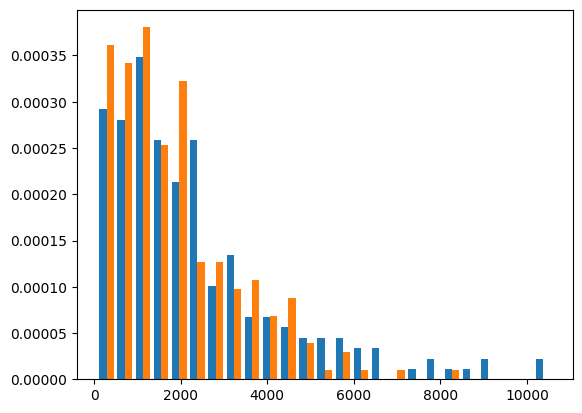

In [92]:
plt.hist(
    [
        (callset_df
            .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
            .select(
                (
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
                ).alias("upper_bound")            
            )
            ["upper_bound"]
        ),
        (sim_callset_df
            .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
            .select(
                (
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
                    pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
                ).alias("upper_bound")            
            )
            ["upper_bound"]
        ),
    ],
    bins=25,
    density=True,
);

In [162]:
%%time
inference.maximum_likelihood_all_reads(
    sampled_callset_df["read_length"].to_numpy(),
    sampled_callset_df["mid_quality_snp_positions"].to_numpy(),
    sim_idx_transitions,
    sampled_callset_df["between_mid_quality_snps_cM"].to_numpy() * 1e-2,
    sampled_callset_df["before_read_cM"].to_numpy() * 1e-2,
    sampled_callset_df["after_read_cM"].to_numpy() * 1e-2,
    sampled_callset_df["weight"].to_numpy(),
    q_range = (0.03, 1-1e-2),   # Lower end of 0.03 chosen according to observed cMs
    m_range = (0.5, 1),
    GC_tract_mean_range = (1, 100),
    GC_tract_mean2_range = (100, 5000),
    read_margin_in_bp = 5000,
)


KeyboardInterrupt: 

In [ ]:
# Current:	[   0.144    0.98    60.629 2660.276]	

# What is the full distribution from reads

## Test one

In [34]:
row = {
    "read_length": 10000,
    "high_quality_snp_positions": [4000, 5001, 6010, 6500],
    "between_high_quality_snps_cM": [1e-2, 2e-2, 3e-2, 1e-2, 1e-2],
    "before_read_cM": 1e-3,
    "after_read_cM": 1e-3,
}


In [35]:
%%time
D = inference.tract_length_upper_bound_dist_from_read(
    row["read_length"],
    row["high_quality_snp_positions"],
    np.array(row["between_high_quality_snps_cM"]) * 1e-2,
    row["before_read_cM"],
    row["after_read_cM"],
    0.15,
    0.98,
    30,
    1000,
    read_margin_in_bp = 5000,
    max_dist_bin = 30000,
)

CPU times: user 257 µs, sys: 79 µs, total: 336 µs
Wall time: 348 µs


In [38]:
np.where(D)[0], D[np.where(D)]

(array([1499, 2010, 2500]), array([0.56561641, 0.4145981 , 0.01978549]))

## Run on many reads

### High quality reads

In [29]:
%%time
idf = callset_df

D_mix, C_mix = inference.tract_length_upper_bound_dist_from_many_reads(
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(idf["weight"].to_numpy()),
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["weight"].to_numpy()),
    q = 0.05,
    m = 0.999,
    GC_tract_mean = 7.1,
    GC_tract_mean2 = 583.7,
    read_margin_in_bp = 5000,
)

D_one, C_one = inference.tract_length_upper_bound_dist_from_many_reads(
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(idf["weight"].to_numpy()),
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_high_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["weight"].to_numpy()),    
    q = 0.065,
    m = 1,
    GC_tract_mean = 1045.4,
    GC_tract_mean2 = 1045.4,
    read_margin_in_bp = 5000,
)



CPU times: user 23min 35s, sys: 11.6 s, total: 23min 46s
Wall time: 3min 29s


### Plot and compare

In [30]:
upper_bound = (callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(1)+1) -
            pl.col("high_quality_snp_positions").list.get(pl.col("high_quality_snps_idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"]
)

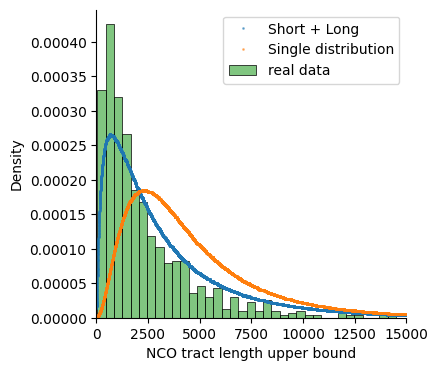

In [32]:
import scipy.ndimage


smooth = 100

fig, ax = plt.subplots(figsize=(4,4))

ax.plot(
    scipy.ndimage.uniform_filter1d(D_mix, smooth), 
    '.', ms=2, alpha=0.5, 
    label="Short + Long",
    color="C0",
);
ax.plot(
    scipy.ndimage.uniform_filter1d(D_one, smooth), 
    '.', ms=2, 
    alpha=0.5, 
    label="Single distribution",
    color="C1",
);
#plt.ylim(0, 0.00005);
ax.set_xlim(0, 15000);


sns.histplot(
    upper_bound,
    ax=ax,
    #kde=True,
    stat="density",
    color="C2",
    bins=50,
    label="real data",
    alpha=0.6,
    linewidth=0.5,
)
# plt.hist(
#     upper_bound,
#     bins=200,
#     density=True,
#     label="real",
# );

plt.legend();

sns.despine(ax=ax)
ax.set_xlabel("NCO tract length upper bound");

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_tract_length.pdf")

In [33]:
conv_df = (callset_df
    .filter(pl.col("high_quality_snps_idx_transitions").list.len() == 2)
    .select(pl.col("high_quality_snps_idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

In [34]:
import statsmodels.stats.proportion

R = np.zeros(10)
for n, c in conv_df.rows():
    R[n] = c

mns = R / R.sum()
cis = [statsmodels.stats.proportion.proportion_confint(c, R.sum()) for c in R]

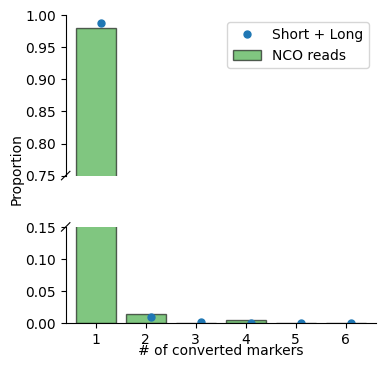

In [41]:
fig = plt.figure(figsize=(4,4))

bax = brokenaxes(xlims=[(0.4, 6.6)], ylims=[(0, 0.15), (0.75, 1)], hspace=.4)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_df["len"].sum(), C_mix) / conv_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_df["len"].sum(), C_mix) / conv_df["len"].sum()

bax.plot(
    np.arange(len(mns))+0.1,
    C_mix, 
    '.', 
    color="C0",
    label="Short + Long",
    ms=10,    
)
bax.errorbar(
    x = np.arange(len(mns))+0.1,
    y = C_mix,
    #yerr = np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_mix, ci_low_mix, ci_high_mix)]).T,
    ls = ' ',
    color='C0',
)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_df["len"].sum(), C_one) / conv_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_df["len"].sum(), C_one) / conv_df["len"].sum()
# bax.plot(
#     np.arange(len(mns))-0.1,
#     C_one, 
#     '.', 
#     color="C1",
#     label="Single distribution",
#     ms=10,
# )
# bax.errorbar(
#     x = np.arange(len(mns))-0.1,
#     y = C_one,
#     #yerr = np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_one, ci_low_mix, ci_high_mix)]).T,
#     ls = ' ',
#     color='C1',
# )


bax.bar(
    x=np.arange(len(mns)),
    height=mns, 
    color=NCO_color,
    alpha=0.6,
    label="NCO reads",
    edgecolor="black",
    linewidth=1,
)

bax.set_xlabel("# of converted markers")
bax.set_ylabel("Proportion");
bax.legend();

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_converted.pdf")

### Mid quality

In [10]:
%%time
idf = callset_df

D_mix_mid, C_mix_mid = inference.tract_length_upper_bound_dist_from_many_reads(
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(idf["weight"].to_numpy()),
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["mid_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_mid_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["weight"].to_numpy()),
    q = 0.142,
    m = 0.982,
    GC_tract_mean = 34.6,
    GC_tract_mean2 = 7214.145,
    read_margin_in_bp = 5000,
)

D_one_mid, C_one_mid = inference.tract_length_upper_bound_dist_from_many_reads(
    # numba.typed.List(idf["read_length"].to_numpy()),
    # numba.typed.List(idf["high_quality_snp_positions"].to_numpy()),
    # numba.typed.List(idf["between_high_quality_snps_bp"].to_numpy() * 1e-8),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(np.repeat(5000 * 1e-8, len(idf))),
    # numba.typed.List(idf["weight"].to_numpy()),
    numba.typed.List(idf["read_length"].to_numpy()),
    numba.typed.List(idf["mid_quality_snp_positions"].to_numpy()),
    numba.typed.List(idf["between_mid_quality_snps_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["before_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["after_read_cM"].to_numpy() * 1e-2),
    numba.typed.List(idf["weight"].to_numpy()),    
    q = 0.409,
    m = 1,
    GC_tract_mean = 217.168,
    GC_tract_mean2 = 1000,
    read_margin_in_bp = 5000,
)



CPU times: user 2h 4min 26s, sys: 27.5 s, total: 2h 4min 53s
Wall time: 14min 38s


In [71]:
upper_bound_mid = (callset_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .select(
        (
            pl.col("mid_quality_snp_positions").list.get(pl.col("idx_transitions").list.get(1)+1) -
            pl.col("mid_quality_snp_positions").list.get(pl.col("idx_transitions").list.get(0))
        ).alias("upper_bound")            
    )
    ["upper_bound"]
)

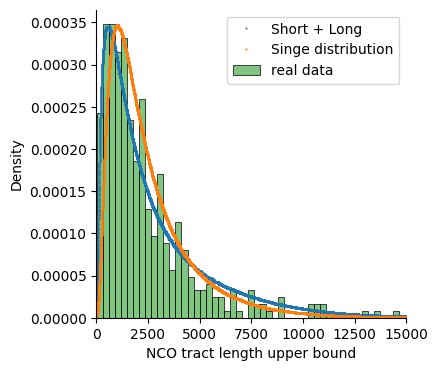

In [187]:
import scipy.ndimage


smooth = 100

fig, ax = plt.subplots(figsize=(4,4))

ax.plot(
    scipy.ndimage.uniform_filter1d(D_mix_mid, smooth), 
    '.', ms=2, alpha=0.5, 
    label="Short + Long",
    color="C0",
);
ax.plot(
    scipy.ndimage.uniform_filter1d(D_one_mid, smooth), 
    '.', ms=2, 
    alpha=0.5, 
    label="Singe distribution",
    color="C1",
);
#plt.ylim(0, 0.00005);
ax.set_xlim(0, 15000);


sns.histplot(
    upper_bound,
    ax=ax,
    #kde=True,
    stat="density",
    color="C2",
    bins=50,
    label="real data",
    alpha=0.6,
    linewidth=0.5,
)
# plt.hist(
#     upper_bound,
#     bins=200,
#     density=True,
#     label="real",
# );

plt.legend();

sns.despine(ax=ax)
ax.set_xlabel("NCO tract length upper bound");

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_tract_length.pdf")

In [16]:
conv_mid_df = (callset_df
    .filter(pl.col("idx_transitions").list.len() == 2)
    .select(pl.col("idx_transitions").list.diff(null_behavior="drop").list.first().alias("n_converted"))
    .group_by("n_converted")
    .len()
    .sort("n_converted")
)

In [17]:
conv_mid_df

n_converted,len
i64,u32
1,446
2,39
3,12
4,1
5,4
6,2


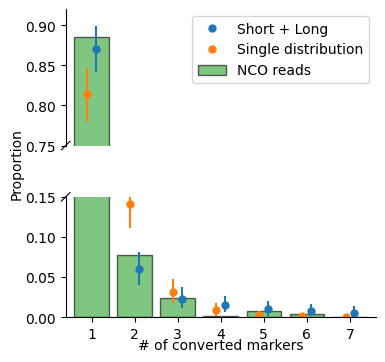

In [22]:
fig = plt.figure(figsize=(4,4))

bax = brokenaxes(xlims=[(0.4, 7.6)], ylims=[(0, 0.15), (0.75, 0.92)], hspace=.4)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_mid_df["len"].sum(), C_mix_mid) / conv_mid_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_mid_df["len"].sum(), C_mix_mid) / conv_mid_df["len"].sum()

R = np.zeros(10)
for n, c in conv_mid_df.rows():
    R[n] = c

mns = R / R.sum()

bax.plot(
    np.arange(len(C_mix_mid))+0.1,
    C_mix_mid, 
    '.', 
    color="C0",
    label="Short + Long",
    ms=10,    
)
bax.errorbar(
    x = np.arange(len(C_mix_mid))+0.1,
    y = C_mix_mid,
    yerr = np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_mix_mid, ci_low_mix, ci_high_mix)]).T,
    ls = ' ',
    color='C0',
)

ci_high_mix = scipy.stats.binom.isf(0.025, conv_mid_df["len"].sum(), C_one_mid) / conv_mid_df["len"].sum()
ci_low_mix = scipy.stats.binom.isf(1-0.025, conv_mid_df["len"].sum(), C_one_mid) / conv_mid_df["len"].sum()
bax.plot(
    np.arange(len(C_mix_mid))-0.1,
    C_one_mid, 
    '.', 
    color="C1",
    label="Single distribution",
    ms=10,
)
bax.errorbar(
    x = np.arange(len(C_mix_mid))-0.1,
    y = C_one_mid,
    yerr = np.array([[mn-ci_low, ci_high-mn] for mn, ci_low, ci_high in zip(C_one_mid, ci_low_mix, ci_high_mix)]).T,
    ls = ' ',
    color='C1',
)


bax.bar(
    x=np.arange(len(mns)),
    height=mns, 
    color=NCO_color,
    alpha=0.6,
    label="NCO reads",
    edgecolor="black",
    linewidth=1,
)

bax.set_xlabel("# of converted markers")
bax.set_ylabel("Proportion");
bax.legend();

bax.set_xticks(
    np.arange(1, 8),
    [str(x) for x in np.arange(1,8)],
)

#fig.savefig("/nfs/treeoflife-01/teams/tola/users/rs42/git/sperm/figures/n_converted.pdf")

# Run it

In [18]:
%%time
prob_factor = 1

idf = callset_df

inference.maximum_likelihood_all_reads(
    idf["read_length"].to_numpy(),
    idf["high_quality_snp_positions"].to_numpy(),
    idf["high_quality_snps_idx_transitions"].to_numpy(),
    idf["between_high_quality_snps_bp"].to_numpy() * 1e-8 * prob_factor,
    numba.typed.List(np.repeat(5000 * 1e-8 * prob_factor, len(idf))),
    numba.typed.List(np.repeat(5000 * 1e-8 * prob_factor, len(idf))),
    idf["weight"].to_numpy(),
    q_range = (1e-10, 0.5),   
    m_range = (1-1e-10, 1-1e-10),
    GC_tract_mean_range = (1, 1),
    GC_tract_mean2_range = (100, 10000),
    prob_factor_range = (1e-10, 1),
    read_margin_in_bp = 5000,
    x0 = [1e-4,   1-1e-10,      1, 1000, 1e-2],
)

# inference.maximum_likelihood_all_reads(
#     idf["read_length"].to_numpy(),
#     idf["high_quality_snp_positions"].to_numpy(),
#     idf["high_quality_snps_idx_transitions"].to_numpy(),
#     idf["between_high_quality_snps_cM"].to_numpy() * 1e-2 * prob_factor,
#     idf["before_read_cM"].to_numpy() * 1e-2 * prob_factor,
#     idf["after_read_cM"].to_numpy() * 1e-2 * prob_factor,
#     idf["weight"].to_numpy(),
#     q_range = (0.05, 0.5),   
#     m_range = (0.8, 1),
#     GC_tract_mean_range = (5, 1000),
#     GC_tract_mean2_range = (100, 10000),
#     read_margin_in_bp = 5000,
#     x0 = [0.05, 0.99, 7, 600],
# )


Current:	[   0.      1.      1.   1000.      0.01]	15917.41616736455
Current:	[   0.      1.      1.   1000.      0.01]	15940.584108357198
Current:	[   0.      1.      1.   1000.      0.01]	15917.41616736455
Current:	[   0.      1.      1.   1000.      0.01]	15917.41616736455
Current:	[   0.      1.      1.   1050.      0.01]	15917.112393599595
Current:	[   0.       1.       1.    1000.       0.011]	15893.300967200954
Current:	[   0.      1.      1.   1020.      0.01]	15884.79078759299
Current:	[   0.      1.      1.   1030.      0.01]	15858.254376359972
Current:	[   0.      1.      1.   1032.      0.01]	15883.701166418965
Current:	[   0.      1.      1.   1044.8     0.01]	15870.969396934195
Current:	[   0.       1.       1.    1062.72     0.011]	15853.907395828342
Current:	[   0.       1.       1.    1094.08     0.011]	15826.319436436266
Current:	[   0.       1.       1.    1030.352    0.011]	15821.536017565926
Current:	[   0.       1.       1.    1020.528    0.012]	15785.484453760051

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 15740.352212877113
             x: [ 9.715e-05  1.000e+00  1.000e+00  1.571e+03  1.821e-02]
           nit: 168
          nfev: 289
 final_simplex: (array([[ 9.715e-05,  1.000e+00, ...,  1.571e+03,
                         1.821e-02],
                       [ 9.715e-05,  1.000e+00, ...,  1.571e+03,
                         1.821e-02],
                       ...,
                       [ 9.715e-05,  1.000e+00, ...,  1.571e+03,
                         1.821e-02],
                       [ 9.715e-05,  1.000e+00, ...,  1.571e+03,
                         1.821e-02]]), array([ 1.574e+04,  1.574e+04,  1.574e+04,  1.574e+04,
                        1.574e+04,  1.574e+04]))

In [27]:
%%time
prob_factor = 1

idf = callset_df

inference.maximum_likelihood_all_reads(
    idf["read_length"].to_numpy(),
    idf["high_quality_snp_positions"].to_numpy(),
    idf["high_quality_snps_idx_transitions"].to_numpy(),
    idf["between_high_quality_snps_cM"].to_numpy() * 1e-2 * prob_factor,
    idf["before_read_cM"].to_numpy() * 1e-2 * prob_factor,
    idf["after_read_cM"].to_numpy() * 1e-2 * prob_factor,
    idf["weight"].to_numpy(),
    q_range = (0.05, 0.5),   
    m_range = (1, 1),
    GC_tract_mean_range = (10, 10),
    GC_tract_mean2_range = (100, 10000),
    read_margin_in_bp = 5000,
    x0 = [0.1, 1, 10, 600],
)


Current:	[  0.1   1.   10.  600. ]	23987.073206731817
Current:	[  0.105   1.     10.    600.   ]	24003.447186338795
Current:	[  0.1   1.   10.  600. ]	23987.073206731817
Current:	[  0.1   1.   10.  600. ]	23987.073206731817
Current:	[  0.1   1.   10.  630. ]	23987.073206731817
Current:	[  0.095   1.     10.    615.   ]	23971.475356880343
Current:	[  0.09   1.    10.   622.5 ]	23956.893907686244
Current:	[  0.095   1.     10.    581.25 ]	23971.475356880343
Current:	[  0.092   1.     10.    601.875]	23964.04006341502
Current:	[  0.089   1.     10.    602.812]	23953.441900516224
Current:	[  0.083   1.     10.    604.219]	23939.09031021216
Current:	[  0.08    1.     10.    604.922]	23932.777764144852
Current:	[  0.07    1.     10.    607.383]	23917.03368671932
Current:	[  0.073   1.     10.    636.738]	23920.0138178958
Current:	[  0.066   1.     10.    633.545]	23914.345971308103
Current:	[  0.052   1.     10.    649.38 ]	23936.234181905085
Current:	[  0.056   1.     10.    618.442]	23924.

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1528e761e910>>
Traceback (most recent call last):
  File "/nfs/users/nfs_r/rs42/rs42/miniforge3/envs/sperm/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


KeyboardInterrupt: 

# Read results from snakemake + bootstrap

In [11]:
import glob, pickle

pcls = glob.glob("/lustre/scratch126/casm/team154pc/sl17/03.sperm/02.results/08.tract_length/inference.sample_every=1.bootstrap=1.rep=*.pcl")
reses = [pickle.load(open(pcl, "rb")) for pcl in pcls]
all_sols = np.vstack([x.x for x in reses])

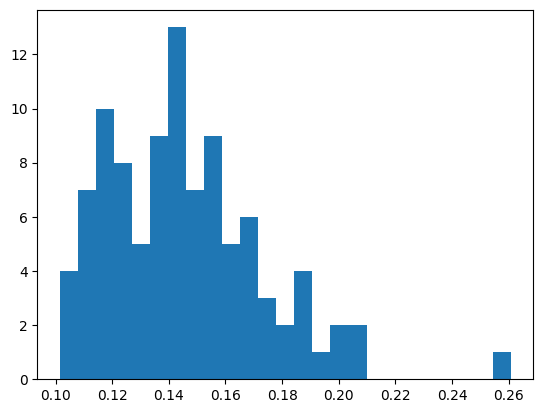

In [214]:
plt.hist(all_sols[:,0], bins=25);

In [215]:
print("CI for q:", np.quantile(all_sols[:,0], q=[0.025, 0.5, 1-0.025]))

CI for q: [0.10543406 0.14208464 0.20236679]


In [14]:
print("CI for m:", 1-np.quantile(all_sols[:,1], q=[0.025, 0.5, 1-0.025]))

CI for m: [0.02849401 0.01872182 0.01180842]


In [217]:
print("CI for L1:", np.quantile(all_sols[:,2], q=[0.025, 0.5, 1-0.025]))

CI for L1: [23.52249596 34.97330938 57.54320209]


In [218]:
print("CI for L2:", np.quantile(all_sols[:,3], q=[0.025, 0.5, 1-0.025]))

CI for L2: [ 1022.97678097  7316.43965419 11306.29357007]


In [205]:
np.exp(((2*4 - 2*(-26726.36)) - (2*2 - 2*(-26863.94)))/2)

1.3132703631479545e-59